In [1]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap

/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob

In [3]:
data = pd.read_csv('data/new_sensor_data_with_glucose.csv')
# Define columns to exclude from NaN checking
exclude_columns = ['timestamp', 'participant', 'state', 'meal', 'temp1', 'temp2', 'glucose_value','runindex']
# Get columns to check for NaN values
columns_to_check = data.columns.difference(exclude_columns)
# Drop rows with NaN values in any of the columns we're checking
data_cleaned = data.dropna(subset=columns_to_check)
data = data_cleaned

In [4]:
# Prepare data for ML training with proper feature handling
print("Data shape:", data.shape)
print("Participants:", data['participant'].unique())

# Convert timestamp to datetime and extract date
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['date'] = data['timestamp'].dt.date

# Remove rows with NaN glucose values for training
data_with_glucose = data.dropna(subset=['glucose_value'])
print(f"Data with glucose values: {data_with_glucose.shape}")

# Check available dates for Alishba
alishba_data = data_with_glucose[data_with_glucose['participant'] == 'alishba']
print(f"Alishba data shape: {alishba_data.shape}")
print("Alishba dates:", sorted(alishba_data['date'].unique()))

# Define features to include: state, meal (categorical), temp1, temp2 (numeric), sensor data (numeric)
# Exclude: timestamp, participant, glucose_value, date, runindex
exclude_features = ['timestamp', 'participant', 'glucose_value', 'date', 'runindex']
feature_columns = [col for col in data_with_glucose.columns if col not in exclude_features]
print(f"Number of features (including state, meal, temp1, temp2): {len(feature_columns)}")

# Identify categorical and numeric features
categorical_features = ['state', 'meal']  # Only these are categorical
numeric_features = [col for col in feature_columns if col not in categorical_features]
print(f"Categorical features: {categorical_features}")
print(f"Numeric features (including temp1, temp2): {len(numeric_features)} features")

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

# Create a copy for encoding
data_for_ml = data_with_glucose.copy()
label_encoders = {}

for col in categorical_features:
    if col in data_for_ml.columns:
        le = LabelEncoder()
        # Handle NaN values by converting to string first
        data_for_ml[col] = data_for_ml[col].astype(str)
        data_for_ml[col] = le.fit_transform(data_for_ml[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {le.classes_}")

# Extract features and target
X = data_for_ml[feature_columns].values
y = data_for_ml['glucose_value'].values

print(f"Final feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Create train/test split with temporal splitting (NO VALIDATION SET)
from sklearn.model_selection import train_test_split

# First, separate Alishba's data for temporal splitting
alishba_mask = data_for_ml['participant'] == 'alishba'
alishba_data_ml = data_for_ml[alishba_mask]
other_data = data_for_ml[~alishba_mask]

print(f"Total samples: {len(data_for_ml)}")
print(f"Alishba samples: {len(alishba_data_ml)}")
print(f"Other participants samples: {len(other_data)}")

# Calculate required test set size (around 10% of total data)
total_samples = len(data_for_ml)
target_test_size = int(0.1 * total_samples)
print(f"Target test set size (10%): {target_test_size}")

# Strategy: Use date-based splitting to avoid data leakage
# Get all unique dates from Alishba's data and split by dates
alishba_dates = sorted(alishba_data_ml['date'].unique())
print(f"Alishba has data from {len(alishba_dates)} unique dates: {alishba_dates}")


# Calculate how many dates we need for test set
samples_per_date = [len(alishba_data_ml[alishba_data_ml['date'] == date]) for date in alishba_dates]
print(f"Samples per date: {dict(zip(alishba_dates, samples_per_date))}")

# Split dates into two chronologically separate groups
# Test: most recent dates (~10% of data)
# Train: all remaining dates (~90% of data, including what would have been validation)

# Find test dates (most recent)
cumulative_test = 0
test_dates = []
for date in reversed(alishba_dates):
    date_samples = len(alishba_data_ml[alishba_data_ml['date'] == date])
    if cumulative_test + date_samples <= target_test_size * 1.2:  # Allow 20% tolerance
        test_dates.append(date)
        cumulative_test += date_samples
    else:
        break

# Training dates are all remaining dates (oldest + middle dates, NO validation set)
train_dates = [d for d in alishba_dates if d not in test_dates]

# Sort dates chronologically for clarity
test_dates = sorted(test_dates)
train_dates = sorted(train_dates)

print(f"Train dates: {len(train_dates)} dates ({train_dates[0] if train_dates else 'None'} to {train_dates[-1] if train_dates else 'None'})")
print(f"Test dates: {len(test_dates)} dates ({test_dates[0] if test_dates else 'None'} to {test_dates[-1] if test_dates else 'None'})")


# Create masks for each split
train_mask = alishba_data_ml['date'].isin(train_dates)
test_mask = alishba_data_ml['date'].isin(test_dates)

# Create datasets for each split
alishba_train_data = alishba_data_ml[train_mask]
alishba_test_data = alishba_data_ml[test_mask]

# Add ALL other participants to training set (no validation split)
train_data = pd.concat([alishba_train_data, other_data])
test_data = alishba_test_data  # Only Alishba data for temporal test set

# Sort data frames by participant and date for consistency
train_data = train_data.sort_values(by=['participant', 'date'])
test_data = test_data.sort_values(by=['participant', 'date'])

# Extract features and targets
X_train = train_data[feature_columns].values
y_train = train_data['glucose_value'].values
X_test = test_data[feature_columns].values
y_test = test_data['glucose_value'].values

print(f"Using complete date-based split: train/test dates are completely separate")
print(f"Train samples: {len(X_train)} (Alishba: {len(alishba_train_data)}, Others: {len(other_data)})")
print(f"Test samples: {len(X_test)} (Alishba only: {len(alishba_test_data)})")

# Verify no date overlap
train_dates_set = set(train_dates)
test_dates_set = set(test_dates)
print(f"\nDate overlap verification:")
print(f"Train-Test overlap: {len(train_dates_set & test_dates_set)} dates")
        

        

print(f"\nFinal split sizes:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/total_samples*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/total_samples*100:.1f}%)")

print(f"\nGlucose ranges:")
print(f"Train glucose range: {y_train.min():.1f} - {y_train.max():.1f}")
print(f"Test glucose range: {y_test.min():.1f} - {y_test.max():.1f}")

# Additional summary of temporal split if used
if len(alishba_data_ml) >= target_test_size and len(alishba_dates) >= 2:
    if 'train_dates_set' in locals():
        print(f"\nTemporal Split Summary:")
        print(f"Train date range: {min(train_dates)} to {max(train_dates)} ({len(train_dates)} days)")
        print(f"Test date range: {min(test_dates)} to {max(test_dates)} ({len(test_dates)} days)")
        print("✅ Train and test splits use completely different dates - no temporal leakage!")

Data shape: (10356, 3109)
Participants: ['sameen' 'alishba' 'shahid']
Data with glucose values: (10356, 3110)
Alishba data shape: (6847, 3110)
Alishba dates: [datetime.date(2025, 5, 18), datetime.date(2025, 5, 23), datetime.date(2025, 6, 6), datetime.date(2025, 6, 8), datetime.date(2025, 6, 11), datetime.date(2025, 6, 15), datetime.date(2025, 6, 23), datetime.date(2025, 6, 24), datetime.date(2025, 6, 25), datetime.date(2025, 6, 26), datetime.date(2025, 6, 27)]
Number of features (including state, meal, temp1, temp2): 3105
Categorical features: ['state', 'meal']
Numeric features (including temp1, temp2): 3103 features
Encoded state: ['after' 'before']
Encoded meal: ['breakfast' 'dinner' 'lunch']
Final feature matrix shape: (10356, 3105)
Target vector shape: (10356,)
Total samples: 10356
Alishba samples: 6847
Other participants samples: 3509
Target test set size (10%): 1035
Alishba has data from 11 unique dates: [datetime.date(2025, 5, 18), datetime.date(2025, 5, 23), datetime.date(2025,

In [5]:
# Model training with encoded features (NO VALIDATION SET)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import xgboost as xgb

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Feature matrix shapes after scaling:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

# Define models
models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=1.0, random_state=42),
    'ElasticNet': ElasticNet(alpha=1.0, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    #'ExtraTrees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Function to calculate MARD
def calculate_mard(y_true, y_pred):
    """Calculate Mean Absolute Relative Difference (MARD)"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Train and evaluate models (ONLY ON TEST SET)
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        # Use scaled features for models that benefit from scaling
        if name in ['Ridge', 'Lasso', 'ElasticNet', 'SVR', 'KNN', 'MLP']:
            model.fit(X_train_scaled, y_train)
            test_pred = model.predict(X_test_scaled)
        else:
            # Use original features for tree-based models
            model.fit(X_train, y_train)
            test_pred = model.predict(X_test)
        
        # Calculate metrics for test set only
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        test_mae = mean_absolute_error(y_test, test_pred)
        test_r2 = r2_score(y_test, test_pred)
        test_mard = calculate_mard(y_test, test_pred)
        
        results[name] = {
            'model': model,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_r2': test_r2,
            'test_mard': test_mard,
            'test_pred': test_pred
        }
        
        print(f"  Test - RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R²: {test_r2:.3f}, MARD: {test_mard:.2f}%")
        
    except Exception as e:
        print(f"  Error training {name}: {e}")
        continue

print(f"\nTrained {len(results)} models successfully")

Feature matrix shapes after scaling:
X_train_scaled: (9169, 3105)
X_test_scaled: (1187, 3105)

Training Ridge...
  Test - RMSE: 18.62, MAE: 15.36, R²: -0.295, MARD: 14.33%

Training Lasso...
  Test - RMSE: 16.93, MAE: 14.29, R²: -0.070, MARD: 13.77%

Training ElasticNet...


/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.623e+04, tolerance: 9.543e+02
  model = cd_fast.enet_coordinate_descent(


  Test - RMSE: 17.33, MAE: 15.03, R²: -0.121, MARD: 14.50%

Training SVR...
  Test - RMSE: 19.55, MAE: 15.20, R²: -0.427, MARD: 14.90%

Training KNN...
  Test - RMSE: 22.89, MAE: 16.85, R²: -0.956, MARD: 16.26%

Training MLP...
  Test - RMSE: 16.64, MAE: 12.59, R²: -0.035, MARD: 11.66%

Training LightGBM...


/home/subhashnerella/.local/share/conda/llm/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  Test - RMSE: 16.99, MAE: 13.66, R²: -0.078, MARD: 12.95%

Training XGBoost...
  Test - RMSE: 18.32, MAE: 14.41, R²: -0.253, MARD: 13.71%

Trained 8 models successfully


MODEL PERFORMANCE SUMMARY (TEST SET)
            Test_RMSE  Test_MAE  Test_R2  Test_MARD
Ridge          18.623    15.360   -0.295     14.325
Lasso          16.929    14.286   -0.070     13.767
ElasticNet     17.328    15.028   -0.121     14.497
SVR            19.550    15.199   -0.427     14.900
KNN            22.885    16.851   -0.956     16.258
MLP            16.645    12.592   -0.035     11.660
LightGBM       16.990    13.659   -0.078     12.947
XGBoost        18.317    14.405   -0.253     13.712

BEST MODELS:
Best Test MARD: MLP (11.66%)
Best Test RMSE: MLP (16.64)


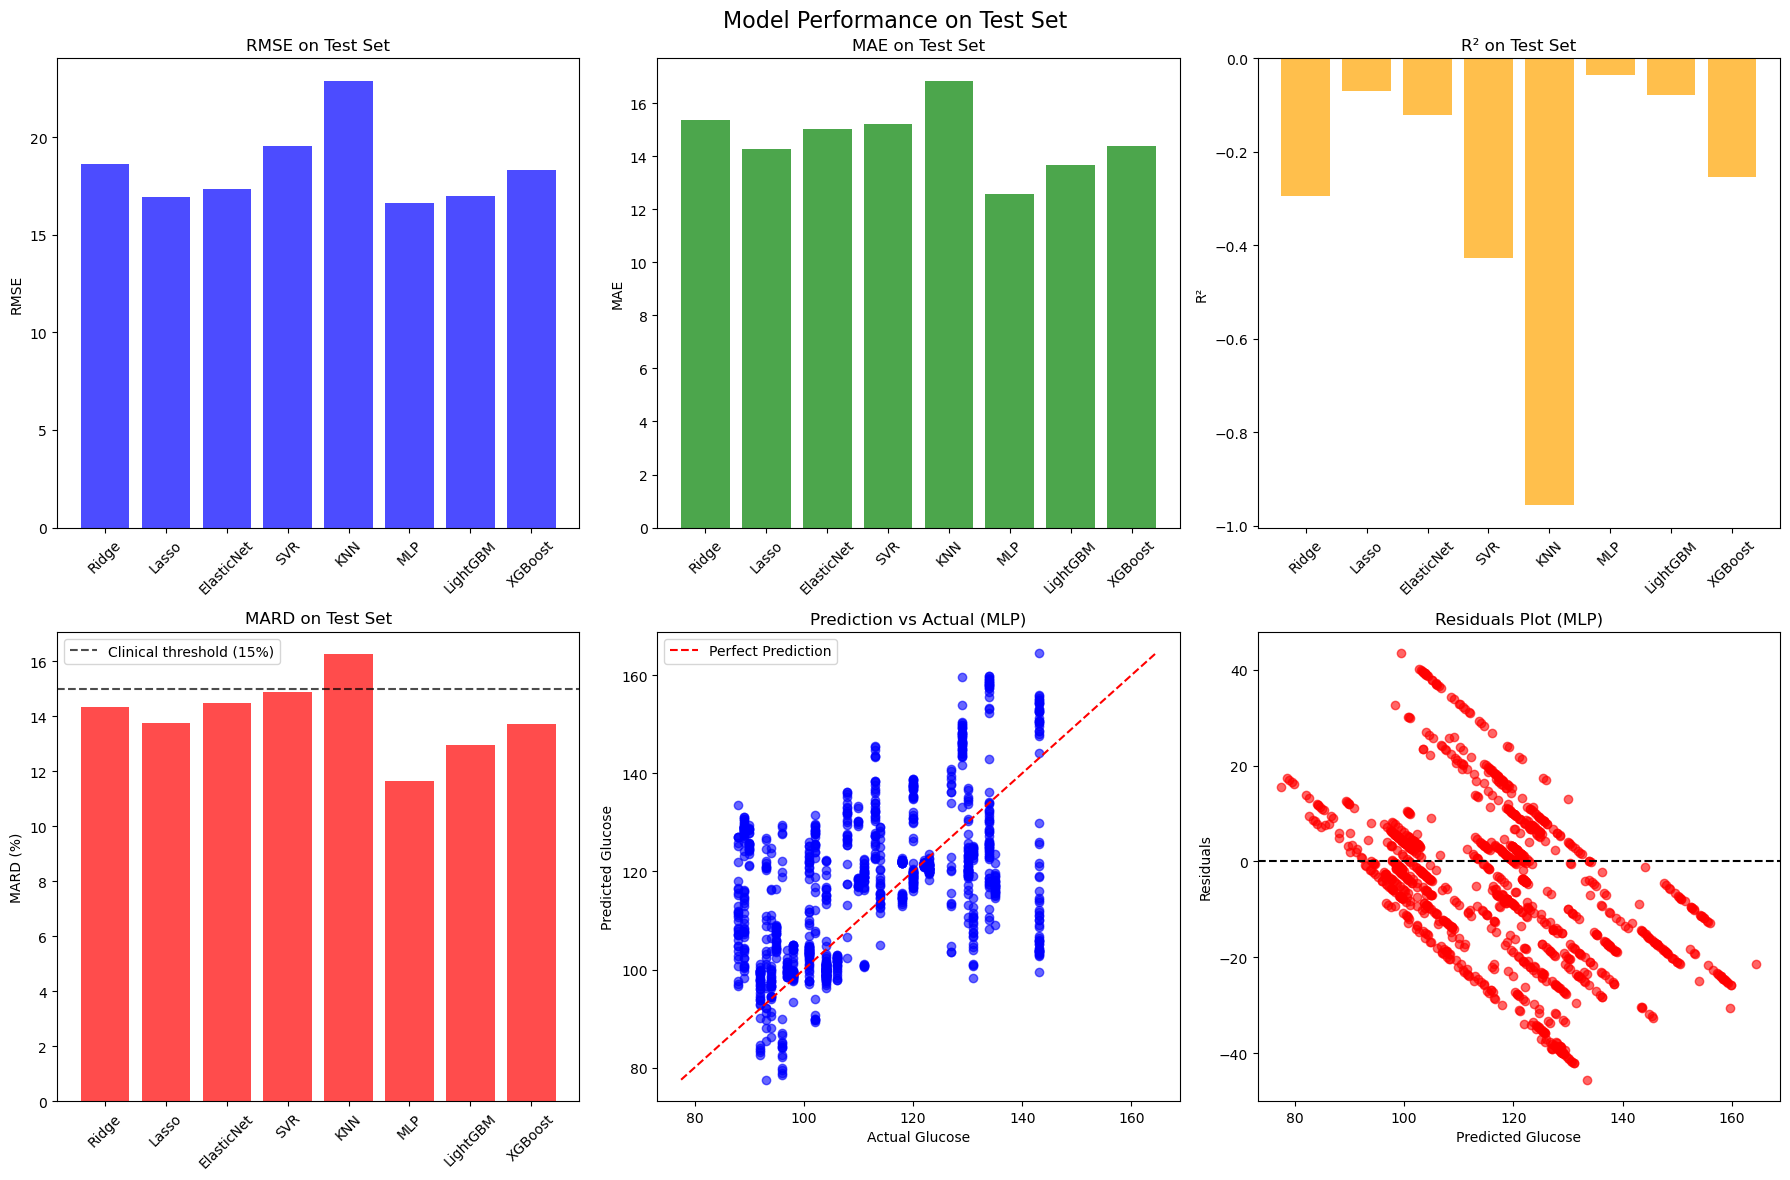

In [6]:
# Model evaluation and visualization (TEST SET ONLY)
import matplotlib.pyplot as plt
import seaborn as sns

# Create comprehensive results summary (TEST ONLY)
results_df = pd.DataFrame({
    model_name: {
        'Test_RMSE': results[model_name]['test_rmse'],
        'Test_MAE': results[model_name]['test_mae'],
        'Test_R2': results[model_name]['test_r2'],
        'Test_MARD': results[model_name]['test_mard']
    }
    for model_name in results.keys()
}).T

print("MODEL PERFORMANCE SUMMARY (TEST SET)")
print("=" * 80)
print(results_df.round(3))

# Find best models
best_test_mard = results_df['Test_MARD'].idxmin()
best_test_rmse = results_df['Test_RMSE'].idxmin()

print(f"\nBEST MODELS:")
print(f"Best Test MARD: {best_test_mard} ({results_df.loc[best_test_mard, 'Test_MARD']:.2f}%)")
print(f"Best Test RMSE: {best_test_rmse} ({results_df.loc[best_test_rmse, 'Test_RMSE']:.2f})")

# Create visualization plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance on Test Set', fontsize=16)

# RMSE comparison
axes[0, 0].bar(results_df.index, results_df['Test_RMSE'], alpha=0.7, color='blue')
axes[0, 0].set_title('RMSE on Test Set')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[0, 1].bar(results_df.index, results_df['Test_MAE'], alpha=0.7, color='green')
axes[0, 1].set_title('MAE on Test Set')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].tick_params(axis='x', rotation=45)

# R² comparison
axes[0, 2].bar(results_df.index, results_df['Test_R2'], alpha=0.7, color='orange')
axes[0, 2].set_title('R² on Test Set')
axes[0, 2].set_ylabel('R²')
axes[0, 2].tick_params(axis='x', rotation=45)

# MARD comparison
axes[1, 0].bar(results_df.index, results_df['Test_MARD'], alpha=0.7, color='red')
axes[1, 0].set_title('MARD on Test Set')
axes[1, 0].set_ylabel('MARD (%)')
axes[1, 0].axhline(y=15, color='black', linestyle='--', alpha=0.7, label='Clinical threshold (15%)')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Prediction vs Actual for best model (based on test MARD)
best_model = best_test_mard
test_pred = results[best_model]['test_pred']

axes[1, 1].scatter(y_test, test_pred, alpha=0.6, color='blue')
min_val = min(min(y_test), min(test_pred))
max_val = max(max(y_test), max(test_pred))
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Glucose')
axes[1, 1].set_ylabel('Predicted Glucose')
axes[1, 1].set_title(f'Prediction vs Actual ({best_model})')
axes[1, 1].legend()

# Residuals plot for best model
test_residuals = y_test - test_pred

axes[1, 2].scatter(test_pred, test_residuals, alpha=0.6, color='red')
axes[1, 2].axhline(y=0, color='black', linestyle='--')
axes[1, 2].set_xlabel('Predicted Glucose')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].set_title(f'Residuals Plot ({best_model})')

plt.tight_layout()
plt.show()



📈 TIME SERIES VISUALIZATION: TEST SET PREDICTIONS
Visualizing predictions from best model: MLP
Test MARD: 11.66%
Test RMSE: 16.64 mg/dL
Test R²: -0.035


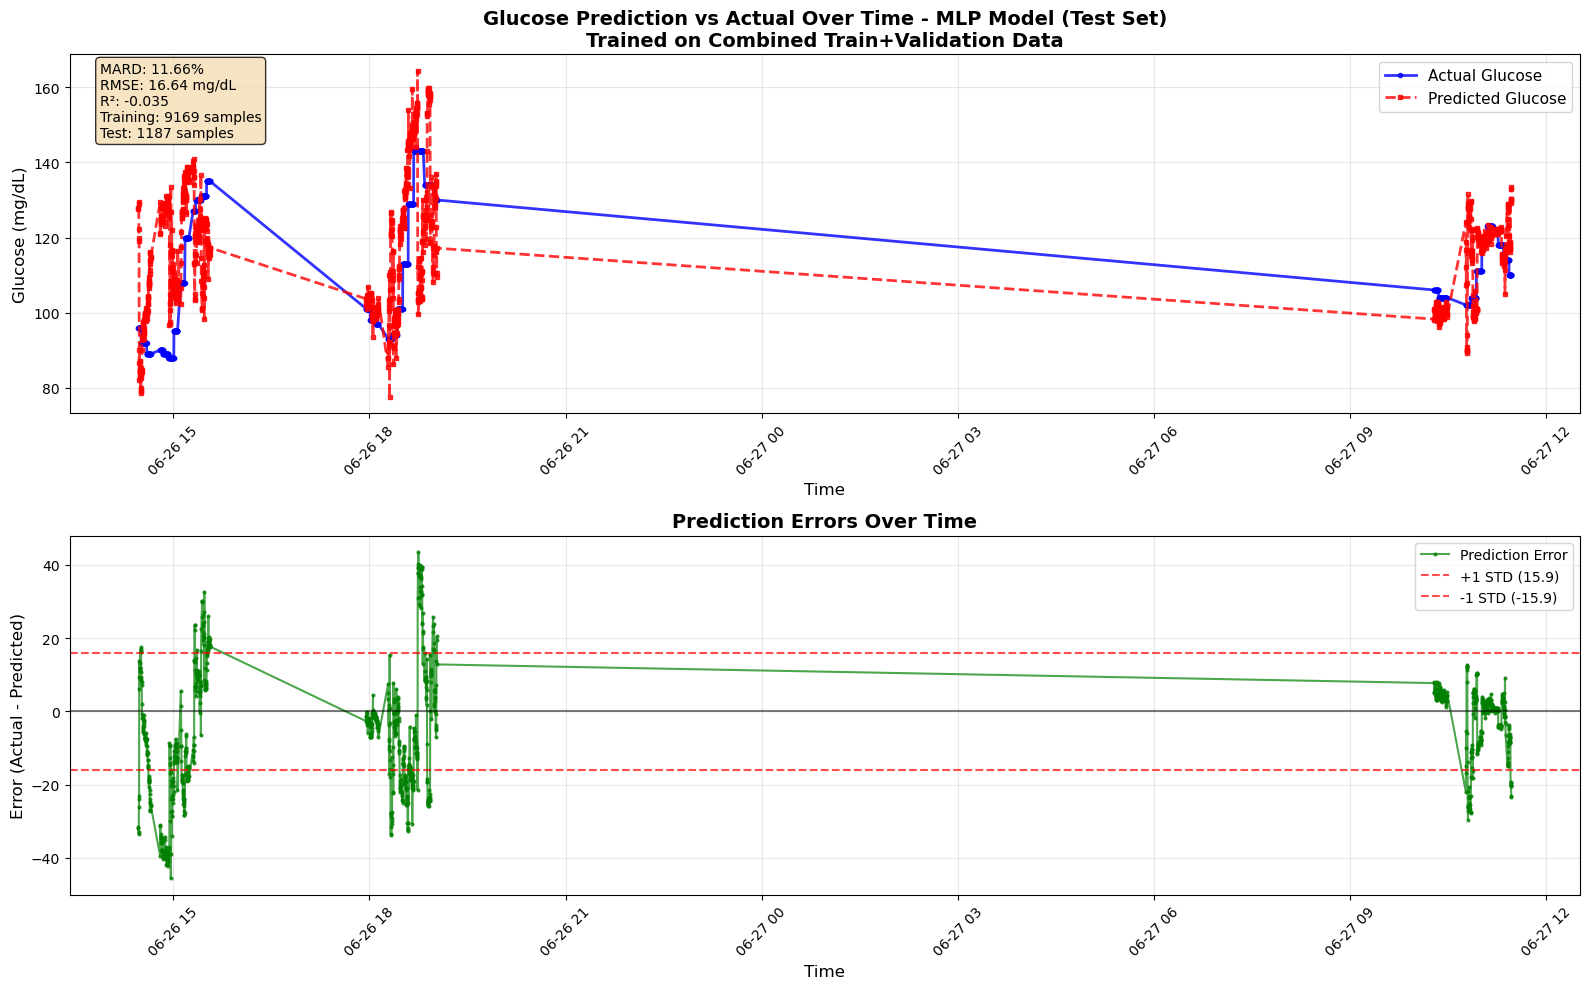


📊 DETAILED TIME SERIES ANALYSIS:
Test period: 2025-06-26 14:28:03.370381 to 2025-06-27 11:27:45.430221
Duration: 21.0 hours
Number of data points: 1187
Sampling frequency: ~56.5 samples/hour

📈 ERROR STATISTICS:
Mean error: -4.89 mg/dL
Error std: 15.92 mg/dL
Mean absolute error: 12.59 mg/dL
Max error: 43.50 mg/dL
Min error: -45.57 mg/dL

🎯 GLUCOSE RANGE ANALYSIS:
Actual glucose range: 88.0 - 143.0 mg/dL
Predicted glucose range: 77.5 - 164.5 mg/dL
Actual glucose mean: 111.8 mg/dL
Predicted glucose mean: 116.7 mg/dL

🏥 CLINICAL ZONE ANALYSIS:
Actual glucose zones:
  Normal: 1187 samples (100.0%)
Predicted glucose zones:
  Normal: 1187 samples (100.0%)

Clinical zone agreement: 1187/1187 (100.0%)

💪 TRAINING DATA UTILIZATION:
Training samples: 9169 (includes former validation data)
Test samples: 1187
Train/Test ratio: 7.7:1
Total data utilization: 100.0%

✅ Time series visualization completed for MLP model trained on expanded dataset!


In [ ]:
# Time Series Plot: Model Predictions vs Actual Glucose Values on Test Set
print("=" * 80)
print("📈 TIME SERIES VISUALIZATION: TEST SET PREDICTIONS")
print("=" * 80)

# Get the best performing model based on test MARD
best_model_name = results_df['Test_MARD'].idxmin()
best_model = results[best_model_name]['model']
best_test_pred = results[best_model_name]['test_pred']

print(f"Visualizing predictions from best model: {best_model_name}")
print(f"Test MARD: {results_df.loc[best_model_name, 'Test_MARD']:.2f}%")
print(f"Test RMSE: {results_df.loc[best_model_name, 'Test_RMSE']:.2f} mg/dL")
print(f"Test R²: {results_df.loc[best_model_name, 'Test_R2']:.3f}")

# Create time series data for test set
# Since test_data contains the original data with timestamps, we can use it for time plotting
test_data_with_time = test_data.copy()
test_data_with_time['predicted_glucose'] = best_test_pred
test_data_with_time['actual_glucose'] = y_test

# Sort by timestamp for proper time series visualization
test_data_with_time = test_data_with_time.sort_values('timestamp')

# Create the time series plot
plt.figure(figsize=(16, 10))

# Main time series plot
plt.subplot(2, 1, 1)
plt.plot(test_data_with_time['timestamp'], test_data_with_time['actual_glucose'], 
         'b-', linewidth=2, alpha=0.8, label='Actual Glucose', marker='o', markersize=3)
plt.plot(test_data_with_time['timestamp'], test_data_with_time['predicted_glucose'], 
         'r--', linewidth=2, alpha=0.8, label='Predicted Glucose', marker='s', markersize=3)

plt.title(f'Glucose Prediction vs Actual Over Time - {best_model_name} Model (Test Set)\nTrained on Combined Train+Validation Data', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Glucose (mg/dL)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add performance metrics as text box
textstr = f'MARD: {results_df.loc[best_model_name, "Test_MARD"]:.2f}%\nRMSE: {results_df.loc[best_model_name, "Test_RMSE"]:.2f} mg/dL\nR²: {results_df.loc[best_model_name, "Test_R2"]:.3f}\nTraining: {len(X_train)} samples\nTest: {len(X_test)} samples'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Error/Residuals plot
plt.subplot(2, 1, 2)
residuals = test_data_with_time['actual_glucose'] - test_data_with_time['predicted_glucose']
plt.plot(test_data_with_time['timestamp'], residuals, 
         'g-', linewidth=1.5, alpha=0.7, marker='o', markersize=2, label='Prediction Error')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.axhline(y=residuals.std(), color='red', linestyle='--', alpha=0.7, label=f'+1 STD ({residuals.std():.1f})')
plt.axhline(y=-residuals.std(), color='red', linestyle='--', alpha=0.7, label=f'-1 STD ({-residuals.std():.1f})')

plt.title('Prediction Errors Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Error (Actual - Predicted)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



# Clinical zones analysis (if applicable)
def glucose_zone(glucose):
    """Classify glucose into clinical zones"""
    if glucose < 70:
        return "Hypoglycemic"
    elif glucose < 180:
        return "Normal"
    else:
        return "Hyperglycemic"

test_data_with_time['actual_zone'] = test_data_with_time['actual_glucose'].apply(glucose_zone)
test_data_with_time['predicted_zone'] = test_data_with_time['predicted_glucose'].apply(glucose_zone)

print(f"\n🏥 CLINICAL ZONE ANALYSIS:")
print("Actual glucose zones:")
actual_zones = test_data_with_time['actual_zone'].value_counts()
for zone, count in actual_zones.items():
    print(f"  {zone}: {count} samples ({count/len(test_data_with_time)*100:.1f}%)")

print("Predicted glucose zones:")
pred_zones = test_data_with_time['predicted_zone'].value_counts()
for zone, count in pred_zones.items():
    print(f"  {zone}: {count} samples ({count/len(test_data_with_time)*100:.1f}%)")

# Zone agreement
zone_agreement = (test_data_with_time['actual_zone'] == test_data_with_time['predicted_zone']).sum()


📈 CLEAN TEST SET VISUALIZATION: BEST MODEL PERFORMANCE
Applying low-pass filter to predictions...
Best Model: MLP
Test MARD: 11.66%
Test RMSE: 16.64 mg/dL
Test MAE: 12.592


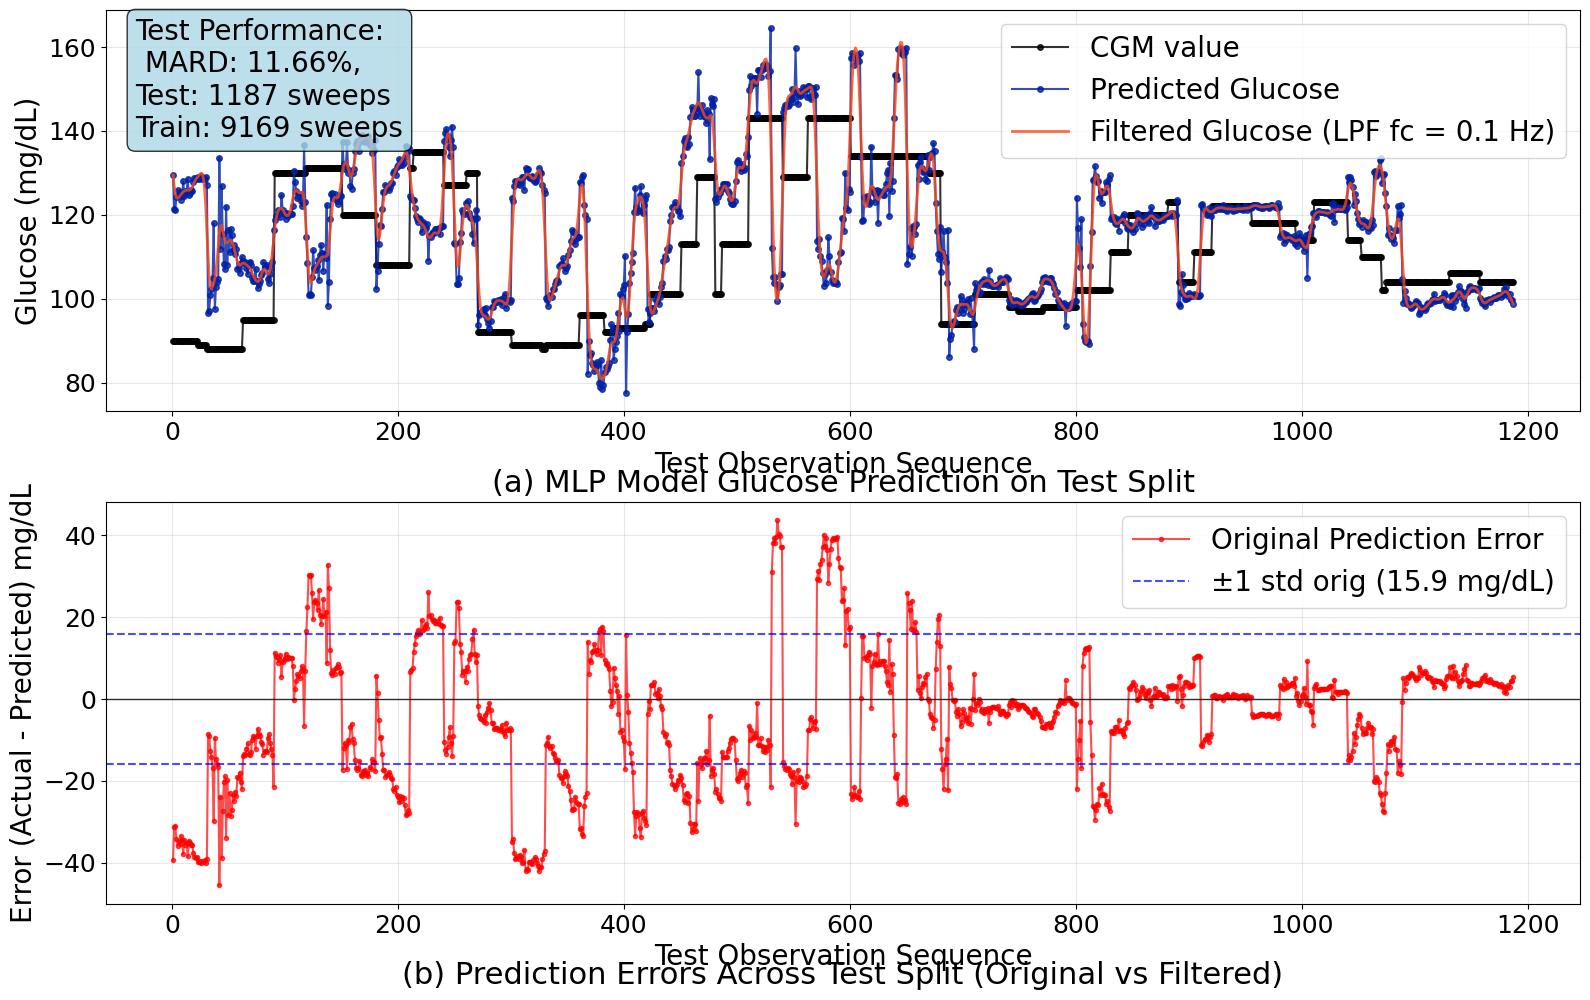


📊 TEST SET SUMMARY:
Total test points: 1187
Glucose range: 88.0 - 143.0 mg/dL
Mean glucose: 111.8 mg/dL

Original Predictions:
Mean absolute error: 12.59 mg/dL
Error standard deviation: 15.91 mg/dL
Points with error >1 std (15.9 mg/dL): 392 (33.0%)

Filtered Predictions:
Mean absolute error: 12.15 mg/dL
Error standard deviation: 15.36 mg/dL
Points with error >1 std (15.4 mg/dL): 377 (31.8%)

🏥 CLINICAL PERFORMANCE COMPARISON:
Original MARD: 11.66%
Filtered MARD: 11.30%
Improvement: 0.36 percentage points

✅ CLINICAL ASSESSMENT (FILTERED): EXCELLENT
   MARD 11.30% < 15% threshold - Clinically acceptable for glucose monitoring

✅ CLINICAL ASSESSMENT (ORIGINAL): EXCELLENT
   MARD 11.66% < 15% threshold - Clinically acceptable for glucose monitoring

💪 TRAINING IMPACT:
Model trained on 9169 samples (expanded training set)
Test evaluation on 1187 completely unseen samples
Filter applied: Low-pass Butterworth (cutoff=0.1, order=2)
Sequential visualization shows model performance across time

In [ ]:
# Clean Plot: Best Model Test Performance with Sequential Time Axis
from scipy.signal import butter, filtfilt

print("=" * 80)
print("📈 CLEAN TEST SET VISUALIZATION: BEST MODEL PERFORMANCE")
print("=" * 80)

def apply_lowpass_filter(signal, cutoff_freq=0.1, order=2):
    """Apply a low-pass Butterworth filter to the signal"""
    try:
        # Normalize the cutoff frequency (must be between 0 and 1)
        nyquist = 0.5  # Assuming normalized frequency
        normal_cutoff = cutoff_freq / nyquist
        
        # Design the filter
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        
        # Apply the filter using filtfilt for zero-phase filtering
        filtered_signal = filtfilt(b, a, signal)
        return filtered_signal
    except Exception as e:
        print(f"Warning: Could not apply filter ({e}), returning original signal")
        return signal

# Get the best model and its predictions
best_model_name = results_df['Test_MARD'].idxmin()
best_test_pred = results[best_model_name]['test_pred']

# Apply low-pass filter to predictions
print("Applying low-pass filter to predictions...")
best_test_pred_filtered = apply_lowpass_filter(best_test_pred, cutoff_freq=0.1, order=2)

print(f"Best Model: {best_model_name}")
print(f"Test MARD: {results_df.loc[best_model_name, 'Test_MARD']:.2f}%")
print(f"Test RMSE: {results_df.loc[best_model_name, 'Test_RMSE']:.2f} mg/dL")
print(f"Test MAE: {results_df.loc[best_model_name, 'Test_MAE']:.3f}")

# Create sequential time points (only where we have glucose values)
n_points = len(y_test)
time_sequence = np.arange(1, n_points + 1)  # Sequential numbering from 1 to n

# Create the clean plot
plt.figure(figsize=(16, 10))

# Main prediction plot
plt.subplot(2, 1, 1)
plt.plot(time_sequence, y_test, 'o-', color='black', linewidth=1.5, alpha=0.8, 
         label='CGM value', markersize=4)
plt.plot(time_sequence, best_test_pred, 'o-', color='#0021A5', linewidth=1.5, alpha=0.8, 
         label='Predicted Glucose', markersize=4)
plt.plot(time_sequence, best_test_pred_filtered, '-', color='#FA4616', linewidth=2, alpha=0.8, 
         label='Filtered Glucose (LPF fc = 0.1 Hz)', markersize=4)

# Add caption for subplot (a) with increased font size
plt.text(0.5, -0.2, f'(a) {best_model_name} Model Glucose Prediction on Test Split', 
         ha='center', transform=plt.gca().transAxes, fontsize=22)

plt.xlabel('Test Observation Sequence', fontsize=20)
plt.ylabel('Glucose (mg/dL)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)  # Increased tick label font size
plt.legend(fontsize=20, loc='upper right')  # Increased legend font size
plt.grid(True, alpha=0.3)

# Add performance metrics as text box
textstr = f'Test Performance:\n MARD: {results_df.loc[best_model_name, "Test_MARD"]:.2f}%, \nTest: {len(y_test)} sweeps\nTrain: {len(X_train)} sweeps'
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=20,
         verticalalignment='top', bbox=props)

# Error plot
plt.subplot(2, 1, 2)
prediction_errors = y_test - best_test_pred
prediction_errors_filtered = y_test - best_test_pred_filtered
error_std = prediction_errors.std()
error_std_filtered = prediction_errors_filtered.std()

plt.plot(time_sequence, prediction_errors, 'o-', color='red', linewidth=1.5, alpha=0.7, 
         markersize=3, label='Original Prediction Error')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
plt.axhline(y=error_std, color='blue', linestyle='--', alpha=0.7, linewidth=1.5, label=f'±1 std orig ({error_std:.1f} mg/dL)')
plt.axhline(y=-error_std, color='blue', linestyle='--', alpha=0.7, linewidth=1.5)

plt.xlabel('Test Observation Sequence', fontsize=20)
plt.ylabel('Error (Actual - Predicted) mg/dL', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)  # Increased tick label font size
plt.legend(fontsize=20)  # Increased legend font size
plt.grid(True, alpha=0.3)

# Add caption for subplot (b) with increased font size
plt.text(0.5, -0.2, '(b) Prediction Errors Across Test Split (Original vs Filtered)', 
         ha='center', transform=plt.gca().transAxes, fontsize=22)

plt.tight_layout()

plt.show()

# Summary statistics
print(f"\n📊 TEST SET SUMMARY:")
print(f"Total test points: {len(y_test)}")
print(f"Glucose range: {y_test.min():.1f} - {y_test.max():.1f} mg/dL")
print(f"Mean glucose: {y_test.mean():.1f} mg/dL")

print(f"\nOriginal Predictions:")
print(f"Mean absolute error: {np.abs(prediction_errors).mean():.2f} mg/dL")
print(f"Error standard deviation: {prediction_errors.std():.2f} mg/dL")
print(f"Points with error >1 std ({error_std:.1f} mg/dL): {np.sum(np.abs(prediction_errors) > error_std)} ({np.sum(np.abs(prediction_errors) > error_std)/len(prediction_errors)*100:.1f}%)")

print(f"\nFiltered Predictions:")
print(f"Mean absolute error: {np.abs(prediction_errors_filtered).mean():.2f} mg/dL")
print(f"Error standard deviation: {prediction_errors_filtered.std():.2f} mg/dL")
print(f"Points with error >1 std ({error_std_filtered:.1f} mg/dL): {np.sum(np.abs(prediction_errors_filtered) > error_std_filtered)} ({np.sum(np.abs(prediction_errors_filtered) > error_std_filtered)/len(prediction_errors_filtered)*100:.1f}%)")

# Calculate MARD for filtered predictions
def calculate_mard(y_true, y_pred):
    """Calculate Mean Absolute Relative Difference (MARD)"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mard_filtered = calculate_mard(y_test, best_test_pred_filtered)

